In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
from scipy.stats import randint
import os
from xgboost import XGBClassifier
import time
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
import multiprocessing


os.makedirs("figures4", exist_ok=True)



In [3]:
df = pd.read_csv(r"C:\Users\ChazinBrahma\Downloads\archive (40)\healthcare_dataset.csv")

In [4]:
cols_to_drop = ['Name', 'Room Number', 'Insurance Provider', 'Doctor', 'Hospital', 'Medication']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

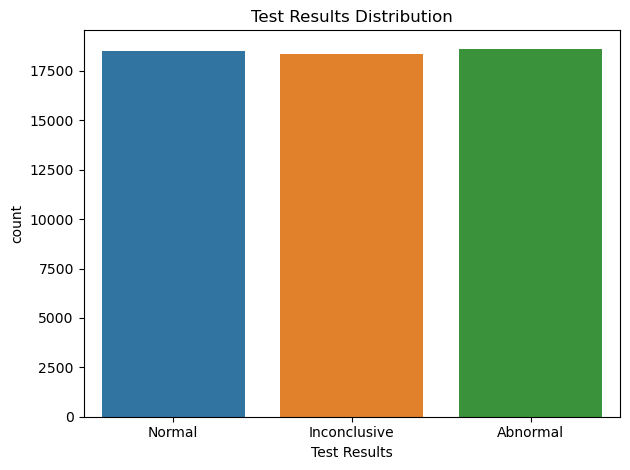

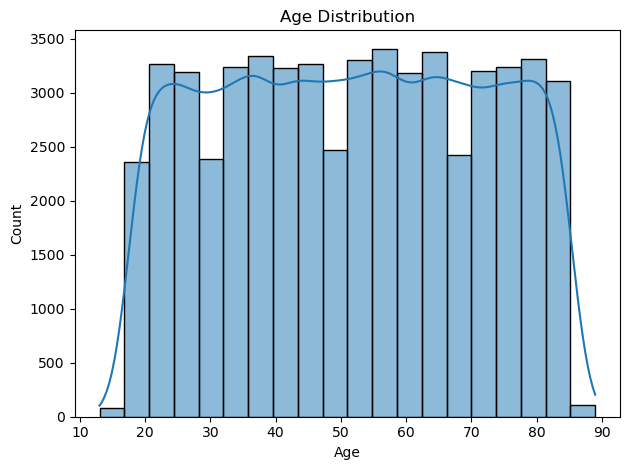

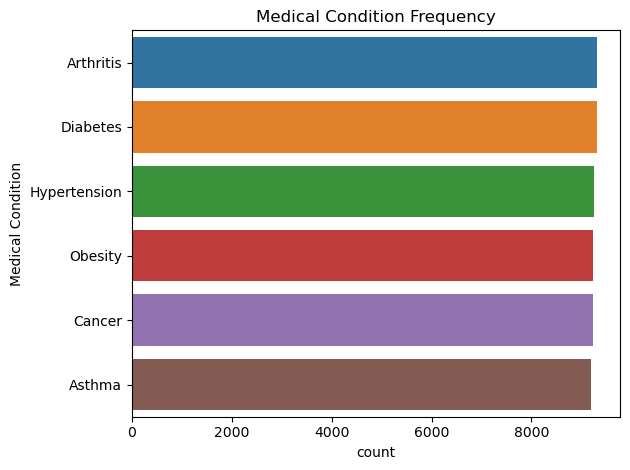

In [5]:
sns.countplot(x='Test Results', data=df)
plt.title('Test Results Distribution')
plt.tight_layout()
plt.savefig('figures4/test_results_distribution.png')
plt.show()


sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.tight_layout()
plt.savefig('figures4/age_distribution.png')
plt.show()


sns.countplot(y='Medical Condition', data=df, order=df['Medical Condition'].value_counts().index)
plt.title('Medical Condition Frequency')
plt.tight_layout()
plt.savefig('figures4/medical_condition_distribution.png')
plt.show()

In [6]:
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df['Length_of_Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
df.drop(['Date of Admission', 'Discharge Date'], axis=1, inplace=True)

df['Age_Billing'] = df['Age'] * df['Billing Amount']


In [7]:
cats = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type']
cats = [c for c in cats if c in df.columns]
df_encoded = pd.get_dummies(df, columns=cats, drop_first=True)


le = LabelEncoder()
df_encoded['Test Results'] = le.fit_transform(df['Test Results'])

X = df_encoded.drop('Test Results', axis=1)
y = df_encoded['Test Results']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))



X_train: (44400, 19), X_test: (11100, 19)
Train class distribution:
 Test Results
0    0.335608
2    0.333649
1    0.330743
Name: proportion, dtype: float64
Test class distribution:
 Test Results
0    0.335676
2    0.333604
1    0.330721
Name: proportion, dtype: float64


In [8]:
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)

print("=== Baseline RF ===")
print(classification_report(y_test, y_pred_base, target_names=le.classes_))
print(f"Baseline RF Accuracy: {accuracy_score(y_test, y_pred_base):.3f}")


=== Baseline RF ===
              precision    recall  f1-score   support

    Abnormal       0.43      0.45      0.44      3726
Inconclusive       0.43      0.42      0.42      3671
      Normal       0.43      0.43      0.43      3703

    accuracy                           0.43     11100
   macro avg       0.43      0.43      0.43     11100
weighted avg       0.43      0.43      0.43     11100

Baseline RF Accuracy: 0.431


In [ ]:
param_dist = {
    'n_estimators': randint(100, 400),        
    'max_depth': randint(5, 30),              
    'min_samples_split': randint(2, 20),      
    'min_samples_leaf': randint(1, 10),       
    'max_features': ['sqrt', 'log2']          
}


rand_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,            
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_search.fit(X_train, y_train)
print("Best RF Params (Randomized):", rand_search.best_params_)

best_rf = rand_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
y_pred_tuned = best_rf.predict(X_test)

print("=== Tuned RF (RandomizedSearchCV) ===")
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))
print(f"Tuned RF Accuracy: {accuracy_score(y_test, y_pred_tuned):.3f}")


cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Tuned RF Confusion Matrix (RandomizedSearchCV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("figures4/confusion_matrix_rf_randomized.png")
plt.show()


In [ ]:
feat_imp = pd.Series(best_rf.feature_importances_, index=X_train.columns)


top20 = feat_imp.sort_values(ascending=False).head(20)


plt.figure(figsize=(10, 6))
top20.plot(kind='bar')
plt.title("Top 20 Feature Importances (Tuned RF)")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("figures4/feature_importance_tuned_rf.png")
plt.show()
